In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas.plotting._matplotlib.core")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import sysconfig
from lib.zigzag import calculate_zigzag
from lib.util import load_json_candles

from tabulate import tabulate
import talib 


In [ ]:

# import sysconfig
# cmodule = 'zigzag'
# f'clear & rm {cmodule}.so & gcc -shared -o {cmodule}.so -fPIC {cmodule}.c -I{sysconfig.get_path("include")} -I{np.get_include()}'

timestamp
2024-01-06 16:00:00         NaN
2024-01-07 00:00:00         NaN
2024-01-07 08:00:00         NaN
2024-01-07 16:00:00         NaN
2024-01-08 00:00:00         NaN
                         ...   
2025-03-13 08:00:00    2.443477
2025-03-13 16:00:00    2.335166
2025-03-14 00:00:00    2.249588
2025-03-14 08:00:00    2.234310
2025-03-14 16:00:00    2.305249
Length: 1300, dtype: float64

In [3]:
def load_data(base, quote, timeframe):
    fname = f'./data/{base}_{quote}-{timeframe}.json'
    return load_json_candles(fname)

def get_window_data(data, start_index_window, window_width):
    ws = start_index_window * window_width
    ww = window_width
    wdata = data.iloc[ws:min(len(data), ws+ww)].copy()
    return wdata



In [4]:
np.linspace(-2,2, 17)


array([-2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,
        0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ])

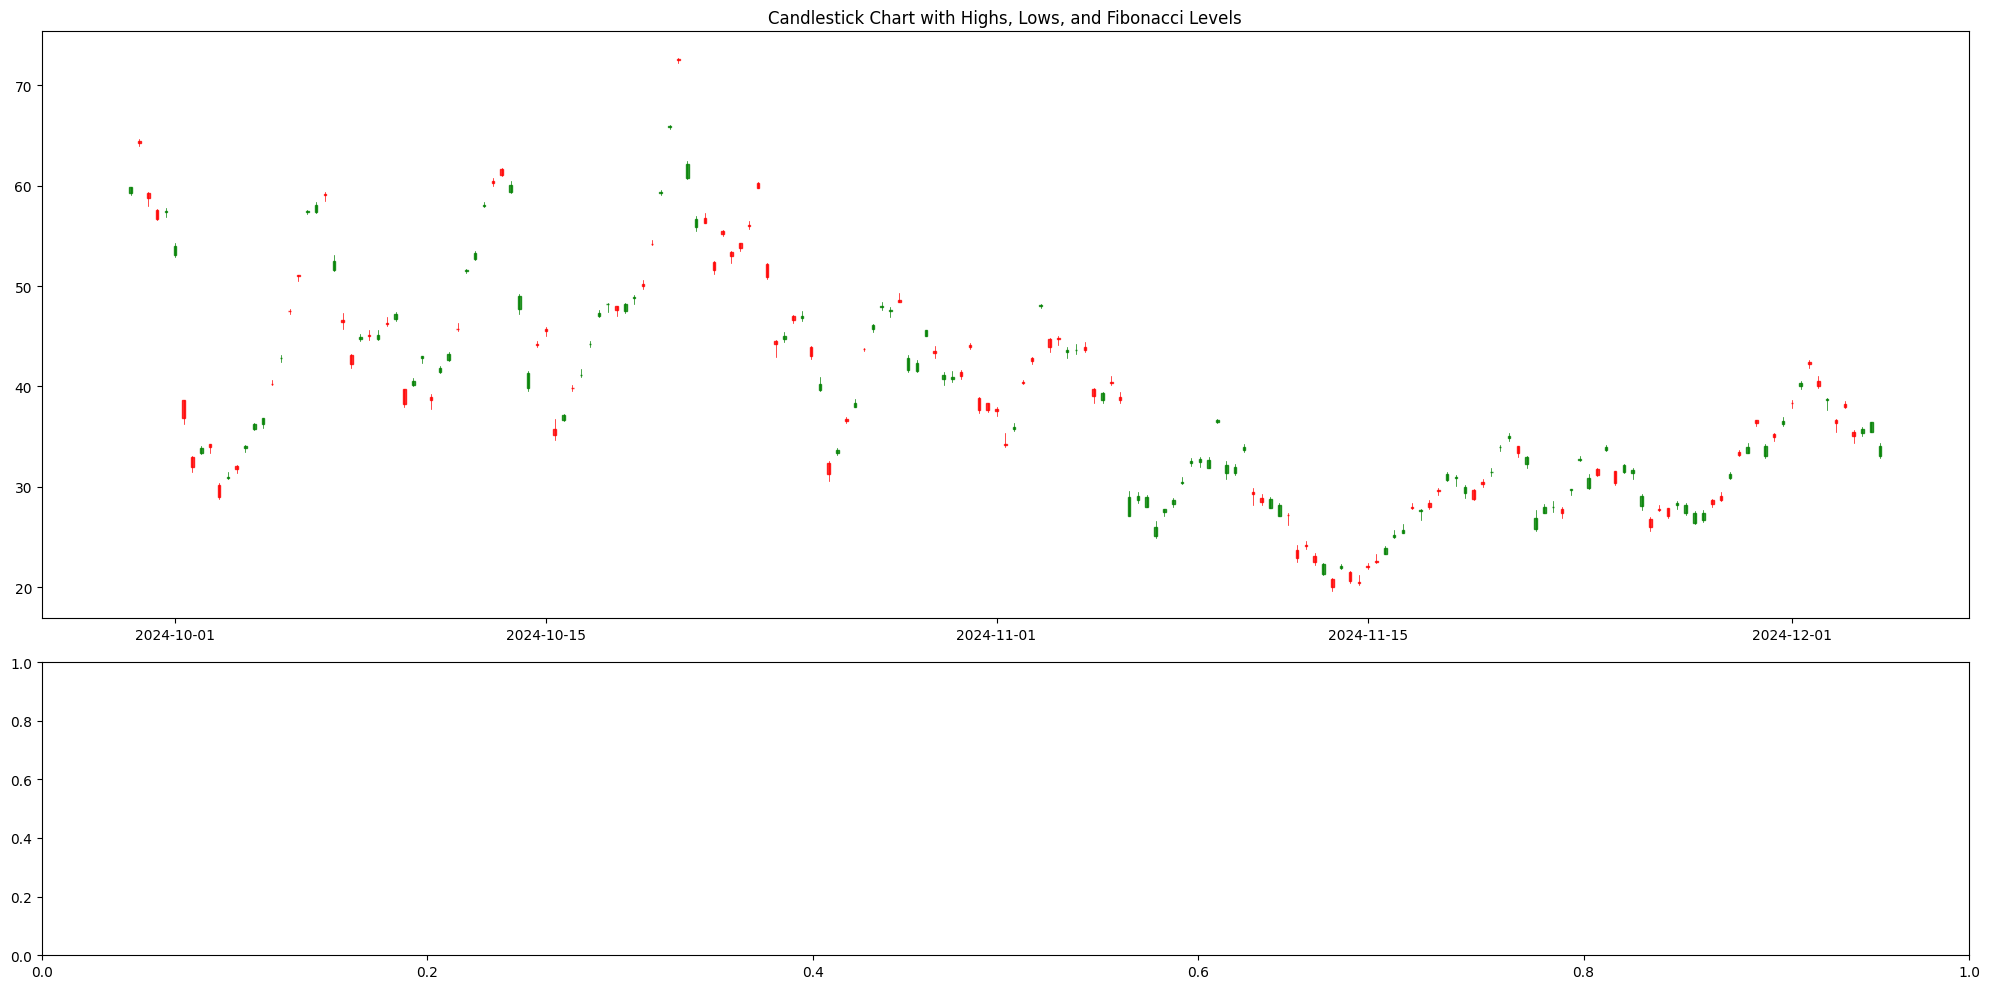

In [ ]:
# fib_levels = np.array([-1.0, -0.786, -0.618, -0.5, -0.414, -0.236, 0.0, 0.236, 0.382, 0.414, 0.5, 0.618, 0.786, 1.0, 1.236, 1.414, 1.5, 1.618, 1.786, 2.0])
# fib_levels = np.array([-1.0, -0.618,  -0.236, 0.0,  0.236, 0.414, 0.618, 1.0, 1.236, 1.618, 2.0])
fib_levels = np.linspace(-2,2, 17)


fib_columns = [f'fib({fib})' for fib in fib_levels]

exchange,base,quote,timeframe = 'binance','ETH', 'USDT', '8h'

data = load_data(base,quote,timeframe).drop(['volume'], axis=1) #.apply(np.log)
roll_period = 6 * 2
st = data.close.rolling(roll_period).std()
# data = data.divide(st , axis=0).dropna()
data = data.divide(talib.ATR(data.high, data.low, data.close, roll_period), axis=0).dropna()
epsilon = 0.2
# highs = data['high'].values
# lows = data['low'].values
highs = lows = data.close.values
# Call the calculate_zigzag function from the C module
high_low_markers, turning_markers = calculate_zigzag(highs, lows, epsilon=epsilon)

extreme_points_ix = np.where(high_low_markers != 0)[0]
extreme_points_hi_ix = np.where(high_low_markers == 1)[0]
extreme_points_lo_ix = np.where(high_low_markers == -1)[0]
extreme_points = high_low_markers[extreme_points_ix]
extreme_prices = np.where(extreme_points == 1, highs[extreme_points_ix], lows[extreme_points_ix])

turning_points_ix = np.where(turning_markers !=0)[0]
turning_points_up_ix = np.where(turning_markers == 1)[0]
turning_points_dn_ix = np.where(turning_markers == -1)[0]
# turning_extremes_ix = np.full(len(high_low_markers), np.nan)

# running_highs_idx = pd.Series(np.where(high_low_markers == 1, 1, np.nan) * np.arange(len(data)), index=data.index).ffill().values
# running_lows_idx = pd.Series(np.where(high_low_markers == -1, 1, np.nan) * np.arange(len(data)), index=data.index).ffill().values

##############################################

# fhigh_low_markers, fturning_markers = zigzag.calculate_zigzag(highs, lows, epsilon=epsilon * 1)

running_highs = pd.Series(np.where(turning_markers == 1, 1, np.nan) * highs).ffill().values
# running_lows = pd.Series(np.where(turning_markers == -1, 1, np.nan) * lows).ffill().values

running_highs = np.full(len(turning_markers), np.nan); 
running_highs[turning_points_dn_ix] = highs[extreme_points_hi_ix[:len(turning_points_dn_ix)]]; 
running_highs = pd.Series(running_highs).ffill().values
# running_highs = running_highs.ffill().values

running_lows = np.full(len(turning_markers), np.nan); 
running_lows[turning_points_up_ix] = lows[extreme_points_lo_ix[:len(turning_points_up_ix)]]; 
running_lows = pd.Series(running_lows).ffill().values
# running_lows = pd.Series(np.where(turning_markers == -1, 1, np.nan) * lows).ffill().values


diff = running_highs - running_lows
fib_matrix = np.outer(diff, fib_levels)
fib_levels_array = running_lows[:, np.newaxis] + fib_matrix
df_fibs = pd.DataFrame(fib_levels_array, columns=fib_columns, index=data.index)

run_diff = (np.cumsum(turning_markers != 0) - np.cumsum(high_low_markers != 0))

# df_fibs = df_fibs.multiply((np.where(run_diff < 0, np.nan, 1)), axis=0)
##############################################
##############################################
ws, ww = len(data)-500, 200
wdata = data.iloc[ws:ws+ww-1].copy()

whighs = wdata.high
wlows = wdata.low

candlestick_ohlc_args={'width': .5 / np.log(len(wdata))}
# candlestick_ohlc_args={}
##############################################
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), height_ratios=[2, 1])

wdata_index = wdata['date_num'] = mdates.date2num(wdata.index)
# Prepare the OHLC data in the format: (date, open, high, low, close)
ohlc = wdata[['date_num', 'open', 'high', 'low', 'close']].values
# Plot the candlesticks
candlestick_ohlc(ax1, ohlc, colorup='green', colordown='red', alpha=0.8, **candlestick_ohlc_args)
# Set y-axis limits based on the close price
# ax1.set_ylim(wlows.min()*0.995, whighs.max()*1.005)

# Format the x-axis to show dates
ax1.xaxis_date()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_title('Candlestick Chart with Highs, Lows, and Fibonacci Levels')
# ax1.legend()
wturning_points_ix = turning_points_ix[(turning_points_ix >= ws) & (turning_points_ix <= ws + ww - 1)]
wextreme_points_ix = extreme_points_ix[(extreme_points_ix >= ws) & (extreme_points_ix <= ws + ww - 1)]
wextreme_points = high_low_markers[wextreme_points_ix]
wextreme_prices = np.where(wextreme_points == 1, highs[wextreme_points_ix], lows[wextreme_points_ix])

# turning_dates = mdates.date2num(wdata.loc[turning_points_idx].index)
# ax1.plot(mdates.date2num(data.index[wextreme_points_ix]), wextreme_prices, color='purple', label='ZigZag Line', lw=1.5)
# for ix in wturning_points_ix:
#     ax1.axvline(data.index.values[ix], color='gray', linestyle='-', alpha=0.2, lw=3)

# df_fibs.loc[wdata.index].plot(ax=ax1, linestyle='--', lw=1)

plt.tight_layout()
plt.savefig('output.png')
plt.show()


In [32]:
# data.isna().sum()
# df_fibs.isna().sum()
# (df_fibs <= 0 ).sum()
# df_fibs[df_fibs <= 0]
# df_fibs.min()
data

,open,high,low,close
timestamp,,,,
2024-01-07 00:00:00,36.878695,37.096929,36.793278,37.016613
2024-01-07 08:00:00,37.890013,38.039272,37.440383,37.581387
2024-01-07 16:00:00,37.992071,38.340174,37.525947,37.831815
2024-01-08 00:00:00,37.657173,37.802620,36.724143,37.702265
2024-01-08 08:00:00,37.020168,38.001405,36.693922,37.777859
...,...,...,...,...
2025-03-13 08:00:00,17.856363,18.341439,17.681541,17.886692
2025-03-13 16:00:00,18.304711,18.384258,17.781555,18.199104
2025-03-14 00:00:00,18.793683,19.205219,18.760623,19.080740


In [ ]:
log_percent_diff#.isna().sum()#.max()

In [ ]:
log_percent_diff = pd.DataFrame({
    (col_data, col_fib): (data[col_data] / df_fibs[col_fib]) - 1
    for col_data in data.columns
    for col_fib in df_fibs.columns
}).dropna()

import statsmodels.api as sm

log_level_entry = data.close.apply(np.log).loc[log_percent_diff.index]

hold_period = 2
fu_close_log = log_level_entry.rolling(hold_period).min().shift(-hold_period).fillna(0)
fu_ret = fu_close_log - log_level_entry

# n_forward = 3
X = log_percent_diff.values
y = fu_ret
# Add a constant term to the predictor variables (for the intercept)
X_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model_sm = sm.OLS(y, X_const).fit()

# Print the model summary
print(model_sm.summary())


## Regression:

## Fib - Level - Reversioni

In [ ]:
# ldata = data.apply(np.log)
# ldf_fibs = df_fibs.apply(np.log)

log_level_entry = data.close.apply(np.log)

hold_period = 6
fu_min = data.low.rolling(hold_period).min().shift(-hold_period)
fu_max = data.high.rolling(hold_period).max().shift(-hold_period)
fu_eop = data.close.shift(-hold_period)
# fu_lmin = ldata.low.rolling(hold_period).min().shift(-hold_period)
# fu_lmax = ldata.high.rolling(hold_period).max().shift(-hold_period)
# fu_leop = ldata.close.shift(-hold_period)

# a + 0.2 * (b - a) = a + 0.2b - 0.2a = (1-0.2)a + 0.2b
pos_sign =  1
# stoploss_fib = 'fib(0.382)'
current_fib = 'fib(0.414)'
target_fib = 'fib(0.786)'
wick_k = 0.3

signal = (data.low < df_fibs[current_fib] - wick_k * (df_fibs[target_fib] - df_fibs[current_fib]) ) & (data.close >= df_fibs[current_fib])

level_target = df_fibs[target_fib]
level_current_fib = df_fibs[current_fib]
log_level_target = level_target.apply(np.log)

sl_k = .5
level_stoploss = level_current_fib - sl_k * (level_target - level_current_fib)
log_level_stoploss = level_stoploss.apply(np.log)
# signal = (data.high > (df_fibs[current_fib] * (1 - wick_k) + df_fibs[next_through_fib] * wick_k) ) & (data.close < df_fibs[current_fib])

# target_hit = signal * (fu_min < df_fibs[target_fib])

stoploos_hit = signal & (level_stoploss - fu_min > 0)
target_hit = signal & (fu_max - level_target > 0) & ~stoploos_hit
# target_hit = np.zeros(signal.shape)
eop_hit = signal * (1 - stoploos_hit ) * (1 - target_hit)
log_level_eop = fu_eop.apply(np.log)
num_signal = signal.sum(); num_target = (target_hit).sum(); num_stoploss = stoploos_hit.sum(); num_eop = eop_hit.sum()

part_stoploss, part_target, part_eop = num_stoploss / num_signal, num_target / num_signal, num_eop / num_signal
# Print the table

log_level_stoploss = level_stoploss.apply(np.log)

stoploss_lrets = stoploos_hit * pos_sign * (log_level_stoploss - log_level_entry).apply(np.expm1)
target_lrets = target_hit * pos_sign * (log_level_target - log_level_entry).apply(np.expm1)
eop_lrets = eop_hit * pos_sign * (log_level_eop - log_level_entry).apply(np.expm1)

print(tabulate([
    # ['% stopped', num_stoploss / num_signal],
    ['num_signal:', num_signal],
    ['num_stoploss:', num_stoploss, 'part_stoploss:', part_stoploss, 'stoploss_lrets:', stoploss_lrets.sum()],
    ['num_target:', num_target, 'part_target:', part_target, 'target_lrets:', target_lrets.sum()],
    ['num_eop:', num_eop, 'part_eop:', part_eop, 'eop_lrets:', eop_lrets.sum()]
    ], tablefmt="grid"))

trades = (target_lrets + stoploss_lrets + eop_lrets)
trades.subtract(np.log1p(0.002)).cumsum().apply(np.expm1).plot(figsize=(8,3))
# print("% stopped ", num_stoploss / num_signal) # fraction of stopped trades
# print(f'num_signal: {num_signal}', f'num_stoploss: {num_stoploss}', f'num_target: {num_target}')

In [ ]:
np.log1p(0.002)